# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
%%time

# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-24 02:58:49+00:00
Last modified datetime for web developer positions in TX:  2021-03-24 03:43:57+00:00
CPU times: user 611 ms, sys: 320 ms, total: 931 ms
Wall time: 16.7 s


### Load JSON Files into Dataframe

In [3]:
# Read the json file into pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Print the number of job postings in each dataframe

print("Number of job postings for data scientists in TX since 2020-12-22: ", df_ds.shape[0])
print("Number of job postings for web developers in TX since 2021-01-04 ", df_wd.shape[0])

Number of job postings for data scientists in TX:  3202
Number of job postings for web developers in TX:  6346


In [10]:
# Print the concise summary of the job postings for data scientists
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3202 entries, 0 to 3201
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3202 non-null   datetime64[ns]
 1   title            3202 non-null   object        
 2   company          3202 non-null   object        
 3   company_rating   3202 non-null   float64       
 4   job_link         3202 non-null   object        
 5   job_description  3202 non-null   object        
 6   city             3202 non-null   object        
 7   state            3202 non-null   object        
 8   zipcode          3202 non-null   int64         
 9   clean            3202 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 250.3+ KB


In [11]:
# Print the most recent 5 job postings for data scientists
df_ds.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-23,Senior DHHS Program Data Analyst,Gainwell Technologies,3.00,https://www.indeed.com/rc/clk?jk=99455d28daf71...,Job Description:\nEssential Job Functions\nDes...,Remote,TX,0,job description essential job function design ...
1,2021-03-23,Data Scientist,Springhead Technologies,3.77,https://www.indeed.com/company/Springhead-Tech...,Skills must have: -BS or MS in Data Science/Ma...,Plano,TX,0,skill must b m data sciencemathapplied math eq...
2,2021-03-23,"Data Engineer, Analytics & Cognitive - Senior ...",Deloitte,4.00,https://www.indeed.com/rc/clk?jk=5651c8e9dee7f...,"Data Engineer, Analytics & Cognitive - Senior ...",Dallas,TX,75201,data engineer analytics cognitive senior consu...
3,2021-03-23,Senior Engineer – Data Science / Software,Parker Drilling,4.00,https://www.indeed.com/rc/clk?jk=f29d5cf284670...,"Company Description\nFounded in 1934, Parker D...",Houston,TX,77046,company description founded 1934 parker drilli...
4,2021-03-23,"Python/SQL Data Engineer, Consultant - Applied...",Deloitte,4.00,https://www.indeed.com/rc/clk?jk=cf1fa5ab8d0a4...,"Python/SQL Data Engineer, Consultant - Applied...",Austin,TX,0,pythonsql data engineer consultant applied art...


In [8]:
# Print the concise summary of the job postings for web developers
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6346 entries, 0 to 6345
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             6346 non-null   datetime64[ns]
 1   title            6346 non-null   object        
 2   company          6346 non-null   object        
 3   company_rating   6346 non-null   float64       
 4   job_link         6346 non-null   object        
 5   job_description  6346 non-null   object        
 6   city             6346 non-null   object        
 7   state            6346 non-null   object        
 8   zipcode          6346 non-null   int64         
 9   clean            6346 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 495.9+ KB


In [13]:
# Print the most recent 5 job postings for web developers
df_wd.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-23,Front End Web Development Lead,Court Avenue,3.71,https://www.indeed.com/rc/clk?jk=6fb5f1f2fa35b...,"At CourtAvenue, you will be a part of a cultur...",Austin,TX,0,courtavenue part culture powered entrepreneur ...
1,2021-03-23,SDET - Software Developer in Test,EZLynx,3.50,https://www.indeed.com/rc/clk?jk=df2d694712c12...,Software Developer Engineer in Test\nEZLynx is...,Lewisville,TX,0,software developer engineer test ezlynx lookin...
2,2021-03-23,C# Developer (Full Stack) USC and local only,ThoughtStorm,3.71,https://www.indeed.com/company/ThoughtStorm-IN...,JOB DESCRIPTION: Application Developer for the...,Arlington,TX,0,job description application developer corporat...
3,2021-03-23,Junior Quality Assurance Engineer,"Management Controls, Inc.",3.71,https://www.indeed.com/rc/clk?jk=fd83b28e004fc...,Description:\n\nManagement Controls Inc. (MCi)...,Houston,TX,77032,description management control inc mci looking...
4,2021-03-23,Senior Web Application Engineer (AWS Cloud),Istation,2.70,https://www.indeed.com/rc/clk?jk=03f4e388161ab...,Istation is looking for a Senior Web Applicati...,Dallas,TX,75206,istation looking senior web application engine...


## Data Preparation

### Consolidation

In [14]:
# Create a job code column: set value 0 for data scientis and 1 for web developers

df_ds = df_ds.assign(job_code = "data scientist")
df_wd = df_wd.assign(job_code = "web developer")

# Concat the two dataframes
df = pd.concat([df_ds, df_wd])

# Inspect the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9548 entries, 0 to 6345
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             9548 non-null   datetime64[ns]
 1   title            9548 non-null   object        
 2   company          9548 non-null   object        
 3   company_rating   9548 non-null   float64       
 4   job_link         9548 non-null   object        
 5   job_description  9548 non-null   object        
 6   city             9548 non-null   object        
 7   state            9548 non-null   object        
 8   zipcode          9548 non-null   int64         
 9   clean            9548 non-null   object        
 10  job_code         9548 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 895.1+ KB


In [15]:
# Set the date as the index and sort in a descending order
df = df.set_index('date').sort_index(ascending=False)

# Rename the columns to be easily understood
df = df.rename(columns={'title': 'job_title', 'clean': 'cleaned_job_description'})

# Inspect the first 5 rows
df.head()

,job_title,company,company_rating,job_link,job_description,city,state,zipcode,cleaned_job_description,job_code
date,,,,,,,,,,
2021-03-23,Senior DHHS Program Data Analyst,Gainwell Technologies,3.00,https://www.indeed.com/rc/clk?jk=99455d28daf71...,Job Description:\nEssential Job Functions\nDes...,Remote,TX,0,job description essential job function design ...,data scientist
2021-03-23,Senior Software Engineer,FloSports,3.30,https://www.indeed.com/rc/clk?jk=034395f089362...,FloSports is a direct-to-consumer subscription...,Austin,TX,78702,flosports directtoconsumer subscriptionbased s...,web developer
2021-03-23,.Net Developer,Datasys Consulting & Software Inc.,3.71,https://www.indeed.com/company/Datasys-Consult...,"Greetings,I'm looking forward to hire a .Net D...",Trent,TX,0,greetingsim looking forward hire net developer...,web developer
2021-03-23,Phoenix Software Engineer II,Bank of America,3.80,https://www.indeed.com/rc/clk?jk=a534237c20a70...,Integrate with multiple data sources such as T...,Addison,TX,0,integrate multiple data source teradata hadoop...,web developer
2021-03-23,Software Engineer,VSP,3.70,https://www.indeed.com/rc/clk?jk=0d55304ad8241...,"Software Engineer\nDate: Mar 22, 2021\nReq ID:...",San Antonio,TX,78202,software engineer date mar 22 2021 req id 4141...,web developer


**Takeaways**
1. Some zipcodes are 0, which indicates they are not provided by the employers.
2. Some values in `city` column are 'Remote', which indicates the jobs do not require a specific location. 
3. So far, all the jobs are located in TX beside the remote ones and the `state` column is kept for geospacial analysis. 

### Handle Missing Values

In [16]:
# Count the missing values in each column
df.isnull().sum(axis=0)

job_title                  0
company                    0
company_rating             0
job_link                   0
job_description            0
city                       0
state                      0
zipcode                    0
cleaned_job_description    0
job_code                   0
dtype: int64

**Takeaways**: No null values has been found in the job postings. 

#### Zipcode

In [17]:
# How many zipcodes are not availabe?
df.zipcode.value_counts(normalize=True).head(1)

0    0.518957
Name: zipcode, dtype: float64

**Takeaways**
1. 52% of the zipcodes are not provided. 
2. How to handle the zipcodes with value 0?
    - option 1: drop the entire column because the ratio of the missing values is more than 50%.
    - option 2: drop the rows but we will lose half of the data. 
    - option 3: impute by the company and its location and it may need outside resource.
3. We choose to drop the `zipcode` column because our dashboard doesn't need the zipcode level of details.

In [18]:
# Drop the zipcode column

df = df.drop(columns='zipcode')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9548 entries, 2021-03-23 to 2020-12-22
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                9548 non-null   object 
 1   company                  9548 non-null   object 
 2   company_rating           9548 non-null   float64
 3   job_link                 9548 non-null   object 
 4   job_description          9548 non-null   object 
 5   city                     9548 non-null   object 
 6   state                    9548 non-null   object 
 7   cleaned_job_description  9548 non-null   object 
 8   job_code                 9548 non-null   object 
dtypes: float64(1), object(8)
memory usage: 745.9+ KB


#### City

In [19]:
# How many jobs are categorized as "Remote" in city column?

num_remote = (df.city == 'Remote').sum()
num_jobs = df.shape[0]
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

577 jobs are remote, which is 6.0% of all the job postings.


**Takeaways**: We will keep the remote jobs and compare their requirements with that of the unremote jobs.

In [20]:
# We noticed that some job titles also contains word "Remote"

mask_remote = ["Remote" in i for i in df.job_title]
print(f"{sum(mask_remote)} job titles contains word 'Remote'")
df[mask_remote].job_title.head()

263 job titles contains word 'Remote'


date
2021-03-23    Senior Software Engineer, Backend (Remote - Te...
2021-03-20                     Lead Front-End Engineer (Remote)
2021-03-19    Senior Full Stack Engineer - Services and Paym...
2021-03-19                     Lead Front-End Engineer (Remote)
2021-03-19      Senior Manager, Data Science (Austin or Remote)
Name: job_title, dtype: object

**Takeaways**: We will change their values in the city column to "Remote" and recompute the percentage of the remote jobs.

In [21]:
# Define a function to change the city in a job posting to "Remote" 
# if word "Remote" is found in the job title

def identify_remote_jobs(job_posting):
    if "Remote" in job_posting.job_title:
        job_posting.city = "Remote"
    return job_posting

In [22]:
%%time
# Change city to "Remote" if job title contains word "Remote"
df = df.apply(identify_remote_jobs, axis=1)

CPU times: user 702 ms, sys: 11.3 ms, total: 713 ms
Wall time: 716 ms


In [23]:
# How many jobs are remote after the adjustment? 
num_remote = (df.city == 'Remote').sum()
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

795 jobs are remote, which is 8.3% of all the job postings.


#### Job Description

In [24]:
# How many job descriptions are missing?

num_missing = (df.job_description == 'error').sum()

print(f"{num_missing} jobs show 'error' in their descriptions, \
which is {round(num_missing*100/num_jobs, 1)}% of all the job postings.")

377 jobs show 'error' in their descriptions, which is 3.9% of all the job postings.


**Takeaways**
1. The value 'error' shows in the `job_descripion` column if the response is Nonetype when making a request to a detailed job posting page. 
2. Because only a small portion (less than 5%) are without the job description, we decide to keep those postings. 

### Clean Job Titles

In [25]:
# Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20)

Data Scientist                  338
Web Developer                   156
Software Engineer               135
Senior Data Scientist           129
Senior Software Engineer        102
Software Developer               94
Full Stack Developer             93
Java Developer                   81
Machine Learning Engineer        74
Senior Data Analyst              74
Front End Developer              73
UI Developer                     59
Sr. Data Scientist               53
PHP Developer                    48
Principal Data Scientist         47
.Net Developer                   46
Full Stack Software Engineer     45
Senior Software Developer        45
Web Designer                     44
Front End Engineer               44
Name: job_title, dtype: int64

**Takeaways**: Some senior positions use the abbreviation of senior - 'Sr.' in the job titles. We decide to use the full spelling so the 'Sr.' need to be replaced with 'Senior'.

In [26]:
# Replace 'Sr.' with 'Senior'
df.job_title = df.job_title.str.replace('Sr.', 'Senior')

# Re-Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20) 

Data Scientist                  338
Senior Data Scientist           182
Web Developer                   156
Software Engineer               135
Senior Software Engineer        126
Senior Data Analyst             114
Software Developer               94
Full Stack Developer             93
Java Developer                   81
Machine Learning Engineer        74
Front End Developer              73
UI Developer                     59
PHP Developer                    48
Principal Data Scientist         47
Senior Software Developer        47
.Net Developer                   46
Full Stack Software Engineer     45
Web Designer                     44
Front End Engineer               44
Web Designer/Developer           41
Name: job_title, dtype: int64

### Clean Company Names

In [27]:
# We noticed Amazon has three names in its job postings

amazon = df.company.str.contains("Amazon")
df[amazon].company.value_counts()

Amazon Web Services, Inc.       57
Amazon.com Services LLC         32
Amazon Dev Center U.S., Inc.     1
Name: company, dtype: int64

In [28]:
# We noticed Dell has two names in its job postings

dell = df.company.str.contains("Dell")
df[dell].company.value_counts()

Dell Technologies    89
Dell                  9
Name: company, dtype: int64

**Takeaways**
1. Although the job postings from Amazon are listed under three different company names, all of them have the same company page on Indeed - Amazon.com. We decide to give them the same company name "Amazon.com"
2. Likewise, we decide to give the job postings from Dell the same company name "Dell Technologies".

In [29]:
# Define a function to clean the company names

def clean_company_names(i):
    if "Amazon" in i:
        i = "Amazon.com"
    elif i == "Dell":
        i = "Dell Technologies"
    return i

In [30]:
# Clean the company names
df.company = df.company.apply(clean_company_names)

In [31]:
# Sanity check
df[amazon].company.value_counts()

Amazon.com    90
Name: company, dtype: int64

In [32]:
# Sanity check
df[dell].company.value_counts()

Dell Technologies    98
Name: company, dtype: int64

### Clean City Column
**Notes**: We noticed that several values in the `city` column are not cities and they are listed below
- Military posts: Fort Same Houston, Lackland AFB in San Antonio
- Metroplex: Dallas-Fort Worth
- Area: Las Colinas: an affluent and upscale area in Irving, TX. 
- Community
    - Geromino, TX: an unincorporated community in Guadalupe Country, TX. 

#### Military Posts

In [33]:
# How many jobs are posted from military posts?

military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

5

**Takeaways**: Only 5 jobs postings are from military posts in San Antonio. We decide to reassign them to San Antonio. 

In [34]:
# Replace military posts with the city where they are located
df.city = df.city.apply(lambda i: "San Antonio" if (i == "Fort Sam Houston") | (i == "Lackland AFB") else i)

# Sanity check
military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

0

#### Metroplex

In [35]:
# How many jobs are posted from Dallas-Fort Forth?

metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

65

In [36]:
# How many companies posted jobsing using Dallas-Fort Worth as location?
df[metroplex].company.nunique()

24

**Takeaways** There are 8 principal cities in this metroplex and they are Dallas, Fort Worth, Arlington, Plano, Irving, Denton, Richardson, and Grapevine. We decide to reassign all of them to city Dallas. 

In [37]:
# Rename as Dallas
df.city = df.city.str.replace("Dallas-Fort Worth", "Dallas")

# Sanity check
metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

0

#### Area

In [38]:
# How many jobs are posted in areas?

area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

7

**Takeaway**
1. Las Colinas is an area in Irving so we decide to replace Las Colinas with Irving.
2. We opened the job posting from New York, TX and found the employer American Express does not specify the city so we decide to assign it as Remote

In [39]:
# Replace the area names in the city column
df.city = df.city.apply(lambda i: "Irving" if i == "Las Colinas" 
                                    else ("Remote" if i == "New York" else i))

# Sanity check
area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

0

### Handle the Reposted Jobs
**Notes**: The first step in the data cleaning in the back end has already removed the duplicated job postings based on the job title, location, company, job link and job description. The duplicates in section indicates the jobs are either reposted or the extra is needed for the same position. So far, we couldn't tell the difference between the two. We assume the majority of them are reposted. 

In [40]:
# How many jobs are reposted in the dataframe?

# Define the columns for identifying duplicates
cols = ['job_title', 'company', 'company_rating', 'job_link', 'city', 'job_code']

# Compute the number of duplicates 
num_duplicates = df.duplicated(subset=cols).sum()

print(f"{num_duplicates} jobs are reposted, \
which is {round(num_duplicates*100/num_jobs, 1)}% of all the job postings.")

2212 jobs are reposted, which is 23.2% of all the job postings.


**Takeaways**
1. Nearly one quarter of new posted jobs are acturally reposted. 
2. We decide to keep the reposts and create a new column `repost` to label each job postings so as to distinguish them. 

In [41]:
# Create a new column name `repost`

reposted = df.duplicated(subset=cols, keep="last") # Make duplicates as True except for the last occurrence
df = df.assign(repost=reposted)

# Sanity check: `repost` column has been created successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9548 entries, 2021-03-23 to 2020-12-22
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                9548 non-null   object 
 1   company                  9548 non-null   object 
 2   company_rating           9548 non-null   float64
 3   job_link                 9548 non-null   object 
 4   job_description          9548 non-null   object 
 5   city                     9548 non-null   object 
 6   state                    9548 non-null   object 
 7   cleaned_job_description  9548 non-null   object 
 8   job_code                 9548 non-null   object 
 9   repost                   9548 non-null   bool   
dtypes: bool(1), float64(1), object(8)
memory usage: 755.3+ KB


In [42]:
# Save as csv file to visualize the brief summary of the job market in 2021

# Define the cols to drop
cols = ['job_link', 'job_description', 'cleaned_job_description']

# Save the job postings in 2021
df.drop(columns=cols).loc["2021"].to_csv("joint_job_postings.csv")

## Data Exploration

### Summary of the Job Market in 2021

In [43]:
# How many jobs are posted in 2021?

df_2021 = df.loc["2021"]
print(f"{df_2021.shape[0]} jobs are posted in 2021 for data scientists and web developers in TX.")

9073 jobs are posted in 2021 for data scientists and web developers in TX.


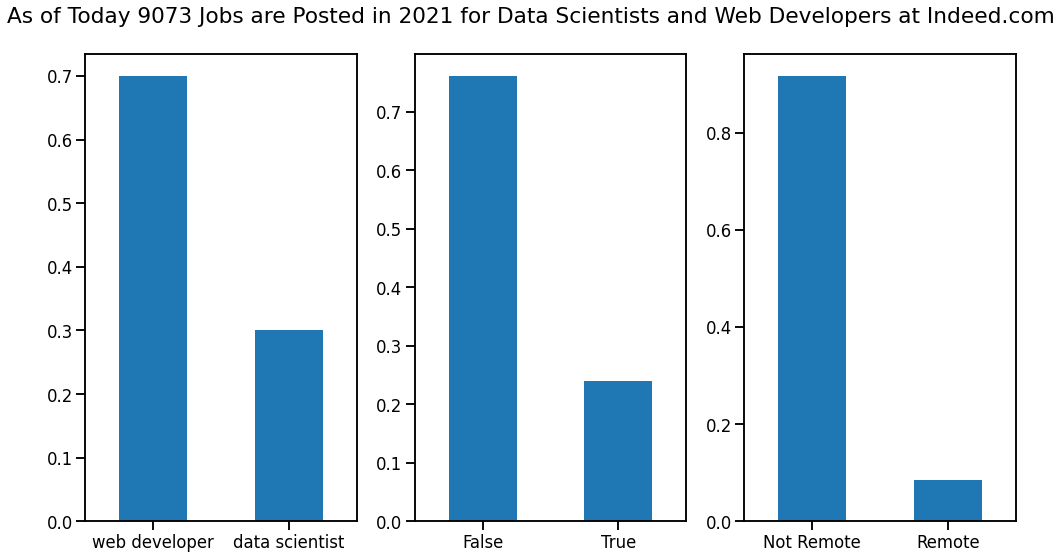

In [44]:
# Set the plotting context parameters
sns.set_context('talk')

fig, axes = plt.subplots(1,3,figsize=(14,8))

df_2021.job_code.value_counts(normalize=True).plot(kind='bar', ax=axes[0], rot="0")
df_2021.repost.value_counts(normalize=True).plot(kind='bar', ax=axes[1], rot="0")
df_2021.city.apply(lambda i: i if i == "Remote" 
                   else "Not Remote").value_counts(normalize=True).plot(kind='bar', ax=axes[2], rot="0")

fig.suptitle("As of Today 9073 Jobs are Posted in 2021 for Data Scientists and Web Developers at Indeed.com")

plt.tight_layout()
plt.show()

**Takeaways**
1. As of today, 8894 jobs have been posted in TX for data scientists and web developers. 
2. About 70% of the jobs are for web developers and 30% for data scientists.
3. Nealry 25% of the jobs are reposted and 8.5% of jobs are remote.

### Where Are the Jobs - Geospatial Analysis

In [45]:
# Remove the remote jobs in 2021

not_remote = (df_2021.city != "Remote")
df_2021_not_remote = df_2021[not_remote]

# Print the number of non-remote jobs
df_2021_not_remote.shape

(8310, 10)

In [46]:
# List the top 10 cities of the highest demand

top10_cities = pd.concat([df_2021_not_remote.city.value_counts().head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).cumsum().head(10)], axis=1)

top10_cities.columns = ['number_of_jobs', 'percent_of_total', 'cumulative_percent_to_total']

top10_cities

,number_of_jobs,percent_of_total,cumulative_percent_to_total
Austin,2720,0.327316,0.327316
Dallas,1356,0.163177,0.490493
Houston,1001,0.120457,0.610951
Plano,739,0.088929,0.699880
San Antonio,487,0.058604,0.758484
Irving,416,0.050060,0.808544
Fort Worth,214,0.025752,0.834296
Richardson,156,0.018773,0.853069
Round Rock,90,0.010830,0.863899
Frisco,72,0.008664,0.872563


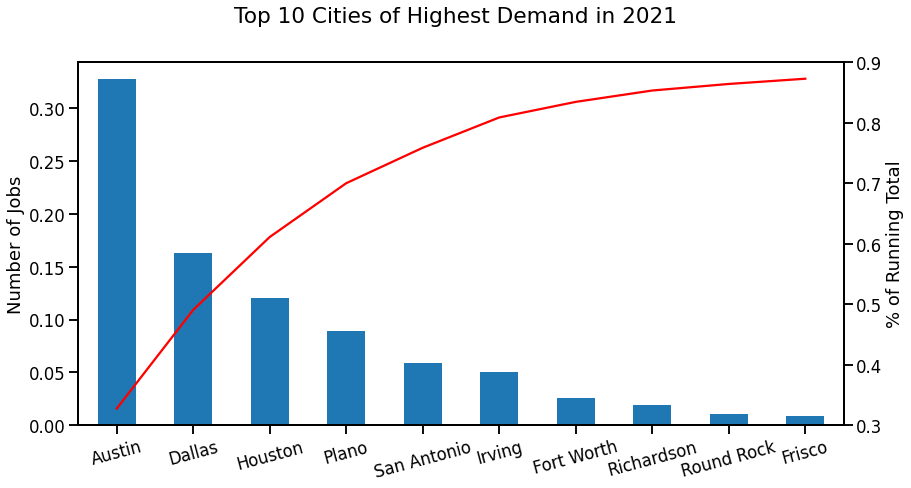

In [50]:
# Visualize the top10 cities by Pareto chart

fig, ax1 = plt.subplots(figsize=(13,7))

# Create a secondary y-axis
ax2 = ax1.twinx()

top10_cities.percent_of_total.plot(kind='bar', ax=ax1, rot='15')
top10_cities.cumulative_percent_to_total.plot(ax=ax2, color='r')

fig.suptitle("Top 10 Cities of Highest Demand in 2021")

ax1.set_ylabel("Number of Jobs")
ax2.set_ylabel("% of Running Total")

ax2.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.tight_layout()
plt.show()

**Takeaways**
1. About 1/3 of jobs are from companies located in Austin. 
2. The top 10 cities together provide almost 90% of the jobs in the job market in 2021. 

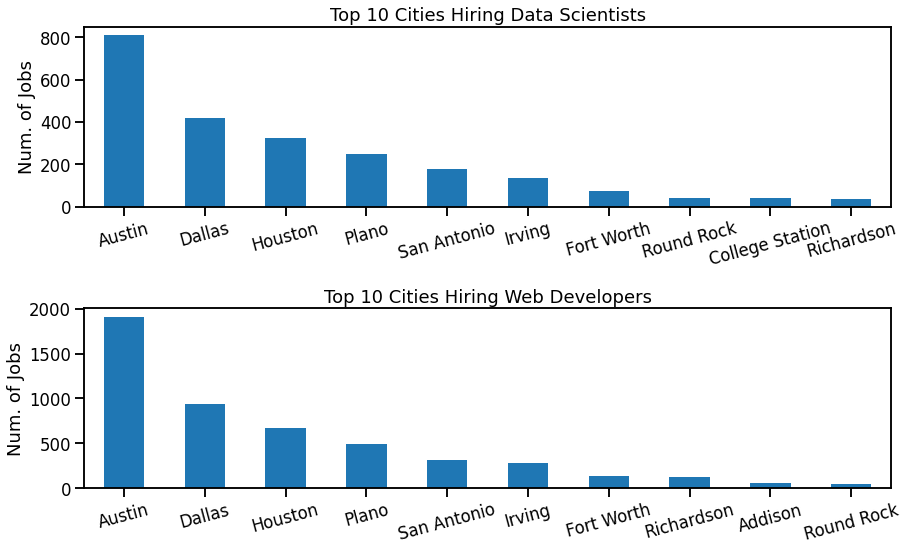

In [49]:
# Compare the top 10 cities that hire data scientists and web developers

# Create a figure and two subplots
fig, axes = plt.subplots(2,1,figsize=(13,8))

df_2021_not_remote_ds = df_2021_not_remote[df_2021_not_remote.job_code == "data scientist"]
df_2021_not_remote_wd = df_2021_not_remote[df_2021_not_remote.job_code == "web developer"]

df_2021_not_remote_ds.city.value_counts().head(10).plot(kind='bar', rot='15', ax=axes[0])
df_2021_not_remote_wd.city.value_counts().head(10).plot(kind='bar', rot='15', ax=axes[1])


# Create the titles
axes[0].set_title("Top 10 Cities Hiring Data Scientists")
axes[1].set_title("Top 10 Cities Hiring Web Developers")

# Create y labels
axes[0].set_ylabel("Num. of Jobs")
axes[1].set_ylabel("Num. of Jobs")

plt.tight_layout()
plt.show()

**Takeaways**:
1. The top 7 cities that hire data scientists are Austin, Dallas, Houston, Plano, San Antonio, Irving, and Fort Worth and it is the exactly the same 7 cities taht hire web developers.
2. The top 7 cities together contributes to 83% of the jobs in the market.

### Who Are Hiring and Who Are Being Hired

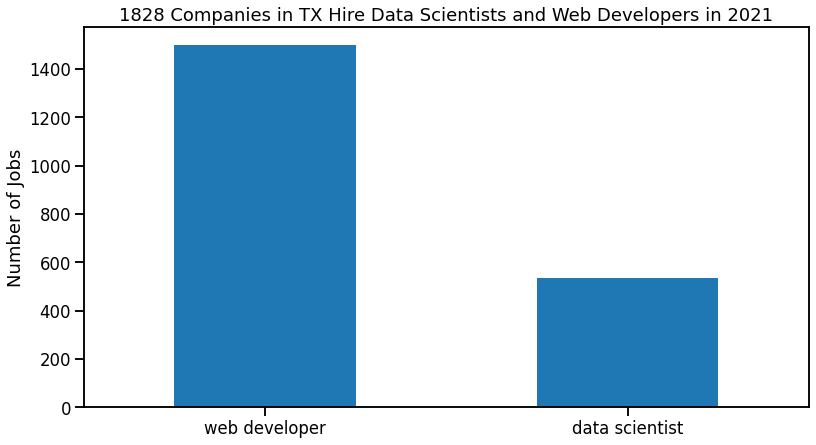

In [75]:
# How many companies hire data scientists and web developers?

# Compute the distinct counts in the `company` column
num_companies = df_2021.company.nunique()

# Group the job postings by the job code and compute the disticnt count in `company` columns 
# And plot the result in a barplot

df_2021.groupby('job_code').company.nunique().sort_values(ascending=False).\
plot(figsize=(13,7), kind='bar', rot=0)

plt.title(f"{num_companies} Companies in TX Hire Data Scientists and Web Developers in 2021")
plt.ylabel("Number of Jobs")
plt.xlabel("")
plt.show()

In [88]:
# How many companies need both and who they are

# Group the job postings by `company` and count the number of distinct job codes in each company
# The comany hires both when the number equals 2

companies_hire_both = df_2021.groupby('company').job_code.nunique()
companies_hire_both = companies_hire_both[companies_hire_both == 2]

print(f"{companies_hire_both.size} companies hire both data scientists and web developer.")
print("Here are 10 of them:")
companies_hire_both.sample(10).index.to_list()

206 companies hire both data scientists and web developer.
Here are 10 of them:


['Sally Beauty Holdings Inc',
 'Center for Autism and Related Disorders, Inc.',
 'Deloitte',
 'CGI Group, Inc.',
 'Broadridge',
 'Sally Holdings LLC',
 'PCS Software',
 'Pricesenz',
 'Annapurna Labs (U.S.) Inc.',
 'Melax Technologies, Inc.']

In [100]:
# Group the obervations by their job_code
group_jobcode = df_2021.groupby('job_code')

# Print the groups names
print(group_jobcode.groups.keys())

# Create seperate dataframes for data scientists and web developers
df_2021_ds = group_jobcode.get_group("data scientist")
df_2021_wd = group_jobcode.get_group("web developer")

dict_keys(['data scientist', 'web developer'])


In [101]:
# Compute the top 10 companies posting most data scientist jobs
# And their number of posts

df_2021_ds.company.value_counts().head(10)

JPMorgan Chase Bank, N.A.         86
Deloitte                          81
Facebook                          61
USAA                              59
Cognizant Technology Solutions    55
Dell Technologies                 52
Amazon.com                        41
Pearson                           41
Accenture                         41
StataCorp                         34
Name: company, dtype: int64

In [102]:
# Compute the top 10 companies posting most web developer jobs
# And their number of posts

df_2021_wd.company.value_counts().head(10)

CyberCoders                            214
JPMorgan Chase Bank, N.A.              208
Indeed                                 131
Cognizant Technology Solutions         110
Infinity Consulting Solutions, Inc.     87
Ad Hoc Team                             87
Tri-Starr Technology                    55
Fannie Mae                              46
Home Depot / THD                        45
Dell Technologies                       43
Name: company, dtype: int64

In [117]:
# Compute the top 10 most popular title for data scientist jobs

df_top10_company_ds = pd.concat([df_2021_ds.job_title.value_counts().head(10),
                                 df_2021_ds.job_title.value_counts(normalize=True).head(10)], axis=1)
df_top10_company_ds.columns=['num_posts', 'percentage']

df_top10_company_ds

,num_posts,percentage
Data Scientist,279,0.102310
Senior Data Scientist,158,0.057939
Senior Data Analyst,96,0.035204
Machine Learning Engineer,55,0.020169
Principal Data Scientist,44,0.016135
Data Engineer,31,0.011368
Data Science Engineer,22,0.008067
Senior Statistical Programmer,21,0.007701
Senior Statistician and Software Developer,20,0.007334
Cloud Data Services Associate,20,0.007334


In [118]:
# Compute the top 10 most popular title for web developer jobs

df_top10_company_wd = pd.concat([df_2021_wd.job_title.value_counts().head(10),
                                 df_2021_wd.job_title.value_counts(normalize=True).head(10)], axis=1)
df_top10_company_wd.columns=['num_posts', 'percentage']

df_top10_company_wd

,num_posts,percentage
Web Developer,156,0.024582
Software Engineer,135,0.021273
Senior Software Engineer,126,0.019855
Software Developer,94,0.014812
Full Stack Developer,93,0.014655
Java Developer,81,0.012764
Front End Developer,73,0.011503
UI Developer,59,0.009297
PHP Developer,48,0.007564
Senior Software Developer,47,0.007406


**Takeaways**
1. More than 1,800 companies post jobs hiring data scientists and/or web developers, of which 206 hire both. 
2. The top 10 companies are listed seperately for the two posistions.

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,sql,1762.0
3,aws,1417.0
4,r,1297.0


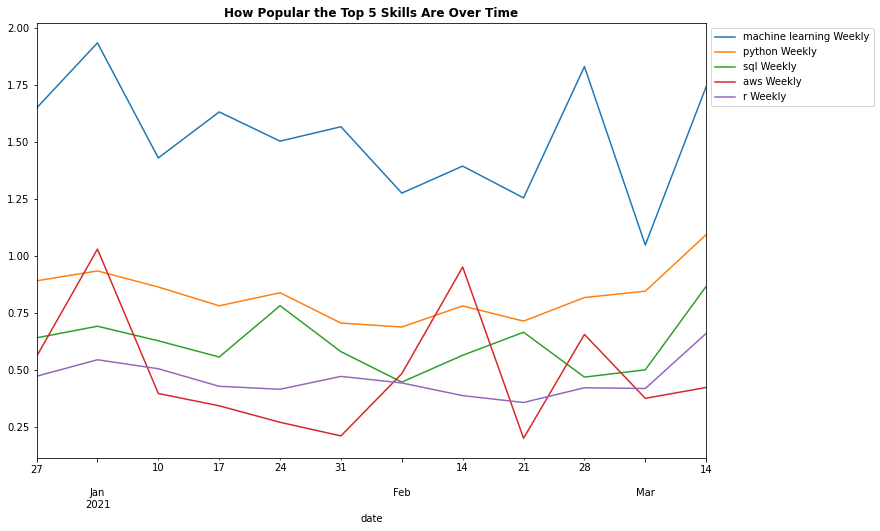

In [17]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [18]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1972.0
1,leadership,1312.0
2,collaboration,572.0
3,problem solving,426.0
4,written communication,330.0


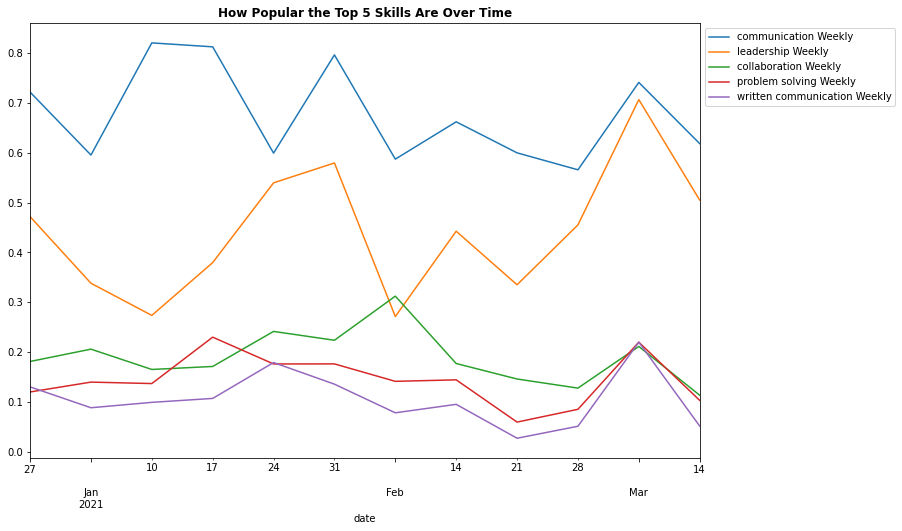

In [19]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [20]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,communication,1972.0
3,sql,1762.0
4,aws,1417.0


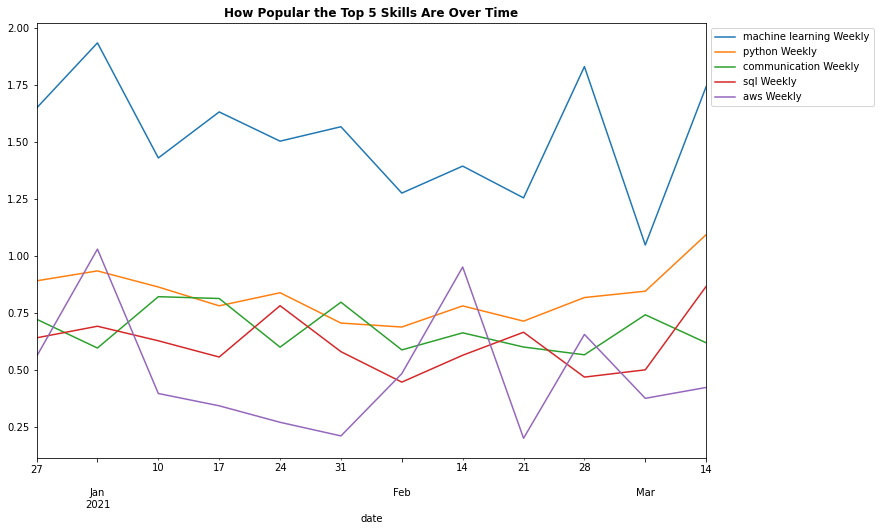

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [22]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4511.0
1,java,3037.0
2,sql,2741.0
3,react,2438.0
4,c,2263.0


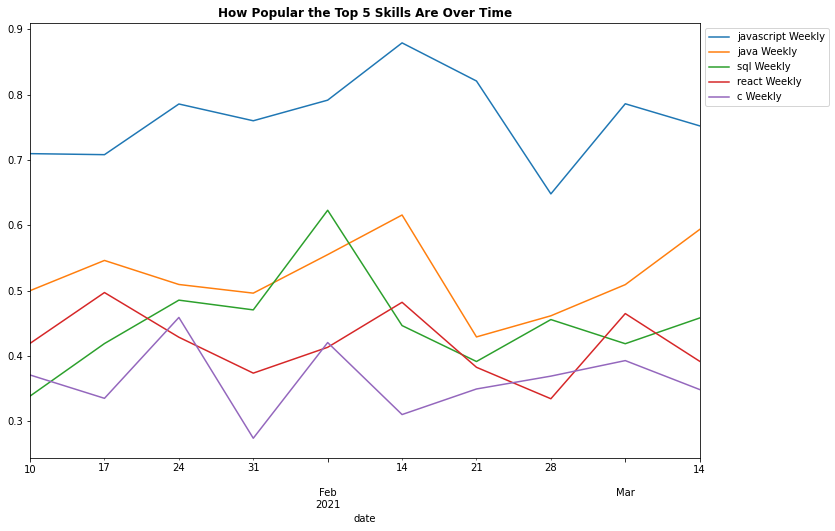

In [23]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [24]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3365.0
1,leadership,1306.0
2,collaboration,896.0
3,problem solving,711.0
4,written communication,504.0


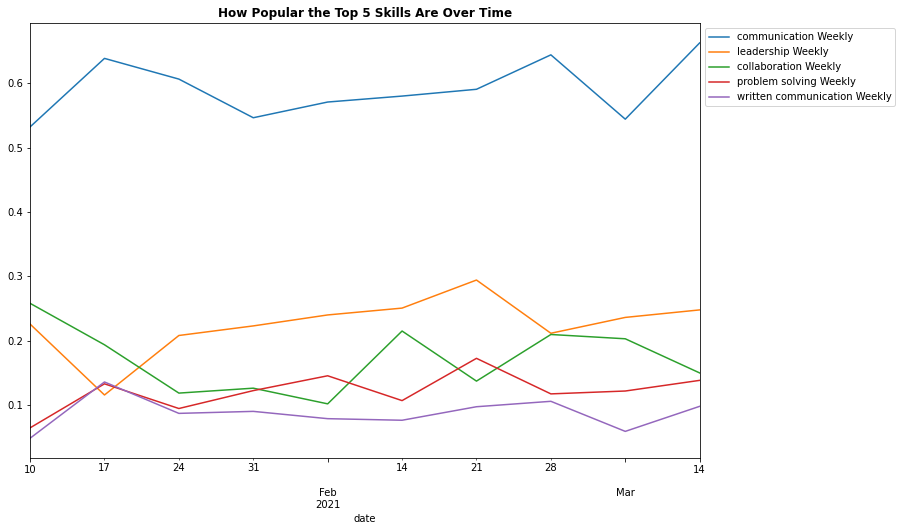

In [25]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [26]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4511.0
1,communication,3365.0
2,java,3037.0
3,sql,2741.0
4,react,2438.0


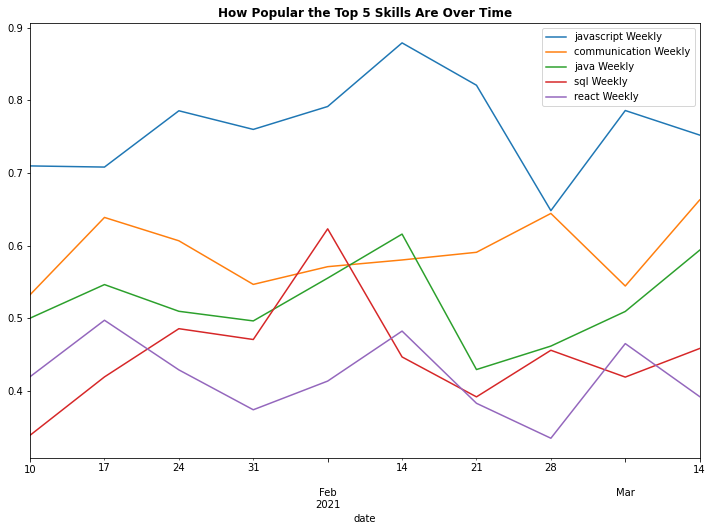

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)